# 01 분류 모델 실습
## ResNet-101

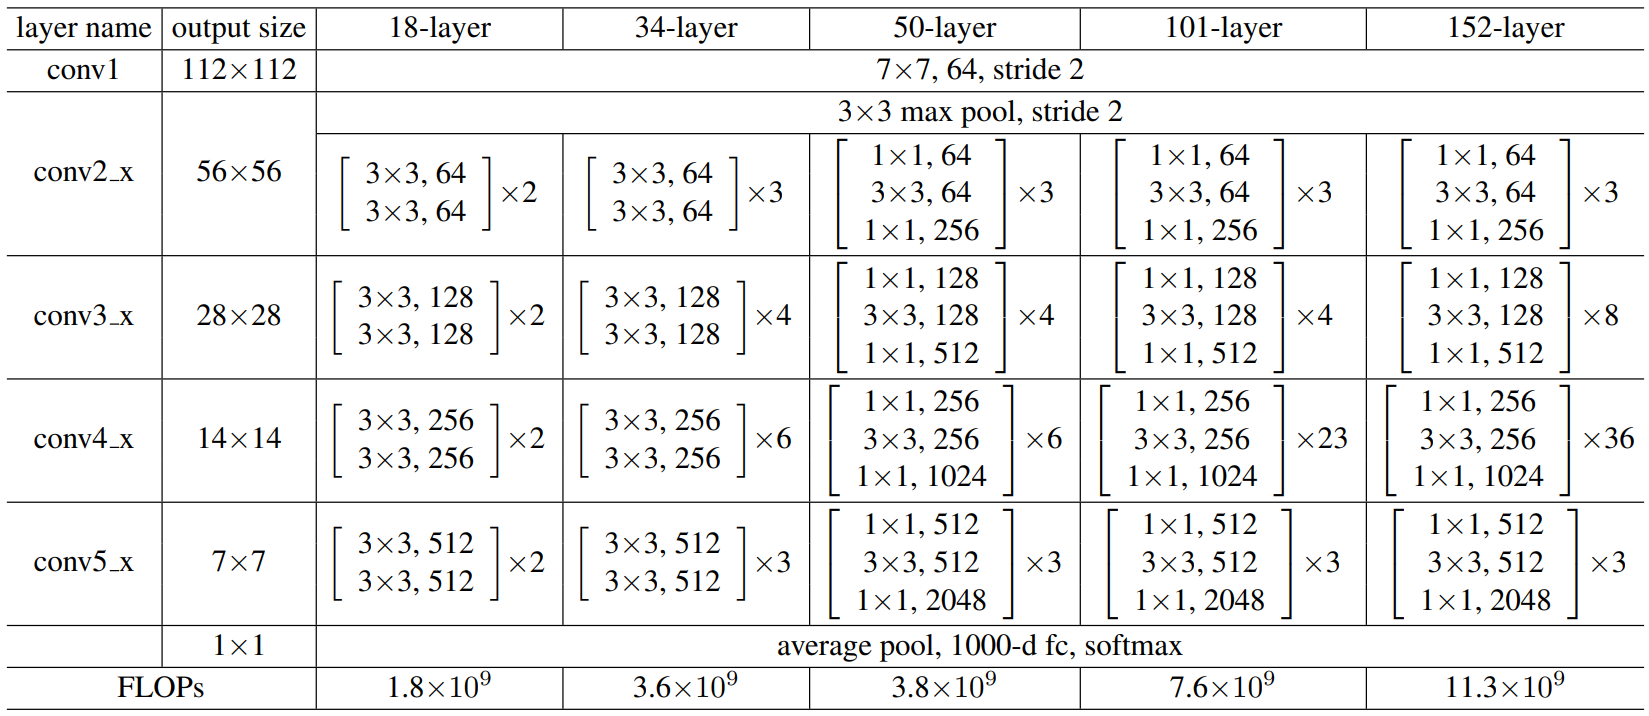

### Import Library

In [1]:
# 라이브러리 임포트
# etc
import os, sys
import glob
import csv
import cv2
import tqdm
from typing import Tuple, List, Dict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# torch library
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# torchvision library
import torchvision
from torchvision import transforms, models
import torch.optim as optim

In [2]:
## 데이터 폴더를 레이블로 사용하게 변환하기
import os
import shutil

def get_label_from_filename(filename):
    age_str = filename.split('_')[2]
    age = int(age_str)
    if age <= 9:
        return '0'
    elif 10 <= age <= 19:
        return '1'
    elif 20 <= age <= 29:
        return '2'
    elif 30 <= age <= 39:
        return '3'
    elif 40 <= age <= 49:
        return '4'
    elif 50 <= age <= 59:
        return '5'
    else:
        return '6'

# Source and destination directories
source_dir_train = "d:\\face_image_data\\train\\re_image"
source_dir_valid = "d:\\face_image_data\\valid\\re_image"
dest_dir_train = "d:\\image_data\\train"
dest_dir_valid = "d:\\image_data\\valid"
dest_dir_test = "d:\\image_data\\test"

# Create new directories
for label in range(7):
    for folder in [dest_dir_train, dest_dir_valid, dest_dir_test]:
        os.makedirs(os.path.join(folder, str(label)), exist_ok=True)

# Copy train images to new train and valid directories
train_image_files = os.listdir(source_dir_train)
for idx, image_file in enumerate(train_image_files):
    label = get_label_from_filename(image_file)
    source_path = os.path.join(source_dir_train, image_file)

    if idx % 5 < 4:  # 80% to train
        dest_path = os.path.join(dest_dir_train, label, image_file)
    else:  # 20% to valid
        dest_path = os.path.join(dest_dir_valid, label, image_file)

    shutil.copy2(source_path, dest_path)

# Copy valid images to new test directory
valid_image_files = os.listdir(source_dir_valid)
for image_file in valid_image_files:
    label = get_label_from_filename(image_file)
    source_path = os.path.join(source_dir_valid, image_file)
    dest_path = os.path.join(dest_dir_test, label, image_file)
    shutil.copy2(source_path, dest_path)

print("Files have been successfully reorganized.")

Files have been successfully reorganized.


### Dataset

In [2]:
# # 데이터 전처리
# train_transform = transforms.Compose(
#     [
#         transforms.RandomHorizontalFlip(),
#         # transforms.RandomChoice([
#         # transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
#         # transforms.RandomResizedCrop(224),
#         # transforms.RandomAffine(
#         #     degrees=15, translate=(0.2, 0.2),
#         #     scale=(0.8, 1.2), shear=15, resample=Image.BILINEAR)
#     # ]),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# val_transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# # 배치 사이즈와 train:validation 비율 정의
# batch_size = 32
# val_size = 0.2

# # torchvision에서 제공하는 CIFAR10 학습 데이터셋 다운로드
# # train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
# #                                         download=True, transform=train_transform)
# # val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
# #                                         download=True, transform=val_transform)

# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=train_transform)
# val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=val_transform)

# # Train 데이터에서 일정 비율 vaildation data 분리
# num_train = len(train_dataset)
# indices = list(range(num_train))
# split = int(np.floor(val_size * num_train))
# train_idx, val_idx = indices[split:], indices[:split]
# train_sampler = SubsetRandomSampler(train_idx)
# val_sampler = SubsetRandomSampler(val_idx)

# # 데이터로더 정의
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
#                                           sampler=train_sampler, num_workers=2)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
#                                           sampler=val_sampler, num_workers=2)

# # torchvision에서 제공하는 CIFAR10 테스트 데이터셋 다운로드
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=val_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

# # 클래스 정의
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 데이터 전처리

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 데이터 로딩
train_dataset = datasets.ImageFolder(root='d:\\image_data\\train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='d:\\image_data\\valid', transform=val_transform)
test_dataset = datasets.ImageFolder(root='d:\\image_data\\test', transform=val_transform)

# 배치 사이즈와 train:validation 비율 정의
batch_size = 8
# batch_size = 32

# 데이터로더 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 클래스 정의
classes = ('0', '1', '2', '3', '4', '5', '6')

In [3]:
# 데이터셋 확인
val_dataset

Dataset ImageFolder
    Number of datapoints: 8030
    Root location: d:\image_data\valid
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

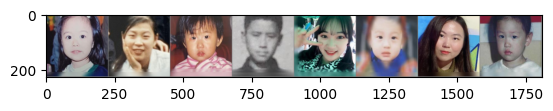

0     2     0     1     1     0     2     0    


In [4]:
# 이미지 데이터 시각화
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습 이미지 얻기
dataiter = iter(train_loader)
images, labels = next(dataiter)
# 이미지 출력
imshow(torchvision.utils.make_grid(images))
# 라벨 프린트
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# # 테스트를 위한 Custom Dataset 다운로드
# !gdown https://drive.google.com/uc?id=1GTES_wxB8b-jsZIqHgNyV9pEgpMLtfzc

Downloading...
From: https://drive.google.com/uc?id=1GTES_wxB8b-jsZIqHgNyV9pEgpMLtfzc
To: /content/03_classification_custom_dataset.zip
100% 77.1k/77.1k [00:00<00:00, 70.1MB/s]


In [ ]:
# # 파일 압축 해제
# !unzip ./03_classification_custom_dataset.zip

Archive:  ./03_classification_custom_dataset.zip
   creating: custom_dataset/
   creating: custom_dataset/cat/
   creating: custom_dataset/car/
  inflating: custom_dataset/.DS_Store  
  inflating: __MACOSX/custom_dataset/._.DS_Store  
   creating: custom_dataset/dog/
   creating: custom_dataset/bird/
   creating: custom_dataset/plane/
  inflating: custom_dataset/cat/alley_cat_s_000013.png  
  inflating: __MACOSX/custom_dataset/cat/._alley_cat_s_000013.png  
  inflating: custom_dataset/cat/alley_cat_s_000777.png  
  inflating: __MACOSX/custom_dataset/cat/._alley_cat_s_000777.png  
  inflating: custom_dataset/cat/alley_cat_s_000157.png  
  inflating: __MACOSX/custom_dataset/cat/._alley_cat_s_000157.png  
  inflating: custom_dataset/cat/alley_cat_s_000585.png  
  inflating: __MACOSX/custom_dataset/cat/._alley_cat_s_000585.png  
  inflating: custom_dataset/cat/alley_cat_s_000030.png  
  inflating: __MACOSX/custom_dataset/cat/._alley_cat_s_000030.png  
  inflating: custom_dataset/car/ambula

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
from typing import Tuple, List
from torch import Tensor

# 커스텀 데이터셋 클래스
class CUSTOMDataset(Dataset):
    def __init__(self, root: str, transforms: transforms = None):
        self.root = root
        self.transforms = transforms
        self.images = []
        self.labels = []

        for folder in os.listdir(self.root):
            if folder == '.DS_Store':
                continue
            
            folder_path = os.path.join(self.root, folder)
            for filename in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, filename))
                
                # 파일명에서 라벨 부분 추출
                label_str = filename.split('_')[2] # 파일명에서 라벨 부분(예: '01') 추출
                label = int(label_str) // 10 if int(label_str) < 60 else 6
                self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        
        label = self.labels[index]
        return image, label


# # 커스텀 데이터셋 클래스
# class CUSTOMDataset(Dataset):
#     def __init__(self, mode: str = 'test', transforms: transforms = None):
#         self.mode = mode
#         self.transforms = transforms
#         self.images = []
#         self.labels = []

#         for folder in os.listdir('./custom_dataset'):
#           files = os.path.join('./custom_dataset', folder)
#           if folder == '.DS_Store':
#             continue
#           files_path = os.listdir(files)
#           for file in files_path:
#             self.images.append(os.path.join(files,file))
#             self.labels.append(classes.index(folder))

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, index: int) -> Tuple[Tensor]:
#         image = Image.open(self.images[index]).convert('RGB')
#         if self.transforms is not None:
#             image = self.transforms(image)
#         image = np.array(image)
#         label = self.labels[index]
#         return image, label

In [5]:
# 커스텀 데이터셋 & 로더
custom_dataset = CUSTOMDataset('d:\\image_data\\test', transforms = val_transform)
custom_loader = DataLoader(
    custom_dataset, batch_size=8, shuffle=False, num_workers=2)

### 모델 불러오기

In [6]:
# 디바이스 체크 & 할당
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model = model.to(device)

Using cache found in C:\Users\tjoeun/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 로스 함수와 옵티마이저 정의

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 학습, 검증, 테스트 메소드 정의

In [9]:
def train(epoch):
  train_loss = 0.0
  model.train()
  for i, data in enumerate(tqdm.tqdm(train_loader), 0):
      # 입력 데이터 가져오기 data: [inputs, labels]
      inputs, labels = data[0].to(device), data[1].to(device)

      # parameter gradients를 제로화
      optimizer.zero_grad()

      # 입력 이미지에 대한 출력 생성
      outputs = model(inputs)

      # 손실함수 계산 밎 업데이트
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

  return train_loss

In [10]:
def val():
  val_loss = 0.0
  val_accuracy = 0.0
  with torch.no_grad():
    # 모델 평가 모드 설정
    model.eval()
    for i, data in enumerate(tqdm.tqdm(val_loader), 0):
      # 입력 데이터 가져오기 data: [inputs, labels]
      inputs, labels = data[0].to(device), data[1].to(device)

      # 입력 이미지에 대한 출력 생성
      outputs = model(inputs)

      # 손실함수 계산
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      # 예측 라벨
      _, predicted = torch.max(outputs, 1)

      # accuracy 계산
      val_accuracy += (predicted == labels).sum().item()

  return val_loss, val_accuracy

In [11]:
def test(test_loader):
    correct = 0
    total = 0
    correct_class = {classname: 0 for classname in classes}
    total_class = {classname: 0 for classname in classes}
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # 입력 이미지에 대한 출력 생성
            outputs = model(inputs)
            # 예측 라벨
            _, predicted = torch.max(outputs.data, 1)
            # 전체 정확도 계산
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # 클래스 별 정확도 계산
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_class[classes[label]] += 1
                total_class[classes[label]] += 1
    # 전체 정확도 출력
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    # 클래스 별 정확도 출력
    for classname, correct_count in correct_class.items():
        if total_class[classname] == 0:
          continue
        accuracy = 100 * float(correct_count) / total_class[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

### 학습

In [12]:
# 학습 에포크 설정
train_epochs = 20
best_acc = 0.0
# 모델 저장 경로 정의
model_path = './1015_7class_resnet101.pth'
for epoch in range(train_epochs):
  # 학습 메소드 실행
  train_loss = train(epoch)
  print(f'[{epoch + 1}] loss: {train_loss / len(train_loader):.3f}')
  # 검증 메소드 실행
  val_loss, val_acc = val()
  vaild_acc = val_acc / (len(val_loader)*batch_size)
  print(f'[{epoch + 1}] loss: {val_loss / len(val_loader):.3f} acc: {vaild_acc:.3f}')
  # 정확도가 기존 베스트를 갱신할 경우 모델 저장
  if vaild_acc >= best_acc:
    best_acc = vaild_acc
    torch.save(model.state_dict(), model_path)
print('Finished Training')

100%|██████████| 4015/4015 [6:42:45<00:00,  6.02s/it]  


[1] loss: 1.102


100%|██████████| 1004/1004 [08:23<00:00,  1.99it/s]


[1] loss: 0.928 acc: 0.600


 39%|███▉      | 1563/4015 [2:35:23<4:03:47,  5.97s/it]


KeyboardInterrupt: 

### 모델 성능평가

커스텀 데이터셋 테스트

In [ ]:
model_path = '/content/7class_resnet.pth'
# 모델 가중치 로드
model.load_state_dict(torch.load(model_path))
# 테스트 메소드 실행
test(custom_loader)

Accuracy of the network on the 10000 test images: 72 %
Accuracy for class: plane is 100.0 %
Accuracy for class: car   is 60.0 %
Accuracy for class: bird  is 40.0 %
Accuracy for class: cat   is 80.0 %
Accuracy for class: dog   is 80.0 %


테스트 데이터셋 테스트

In [ ]:
model_path = '/content/cifar_resnet.pth'
# 모델 가중치 로드
model.load_state_dict(torch.load(model_path))
# 테스트 메소드 실행
test(test_loader)

Accuracy of the network on the 10000 test images: 79 %
Accuracy for class: plane is 82.9 %
Accuracy for class: car   is 86.5 %
Accuracy for class: bird  is 72.5 %
Accuracy for class: cat   is 66.1 %
Accuracy for class: deer  is 75.5 %
Accuracy for class: dog   is 71.4 %
Accuracy for class: frog  is 84.4 %
Accuracy for class: horse is 84.1 %
Accuracy for class: ship  is 86.4 %
Accuracy for class: truck is 87.3 %
